#### Parte I - Análisis de la base de hogares y cálculo de pobreza

##### 1. Analisis exploratorio


Comezamos pensando, solo intuitvamente cuales a priori son las variables que podrian ser utilies para predecir la pobreza y perfeccionar las estimaciones el TP2:

Dentro de la varibles en la encuesta de hogares consideramos relevantes las caracterisicas de la vivienda:
* El tipo de vivienda (IV1)
* Cantidad de habitaciones (IV2)
* Material del techo (V4)
* Revestimiento del techo (IV5)
* Tipo de conexion a agua (IV6 y IV7)
* Tener baño (IV8), tipo de baño (IV9) y equipamiento (IV10)
* Tipo de desague (IV11)
* Zona de ubicacion: cercano a basural (IV12_1), zona inundable (IV12_2) y/o villa de emergecia (IV12_3)


Las caractersiticas habitacionales:
* Cantidad de ambientes (II1)
* Cantidad de dormitorios (II2)
* Habitaccion para trabajo (II3), exlusivamente (II6)
* Tienen: cuarto de cocina (II4_1), lavadero (II4_2), garage (II4_3), cuantos de estos se usan para dormir (II5).
* Regimen de tenencia (II7)
* Combustible para cocinar (II8)
* Propiedad del baño (II9)

Variables de tipo de ingresos: V1 a 18. Y variables de trabajo infantil: V19_A y V19_B

Integrantes del hogar: total (IX_Tot) y menores de 10 (IX_men10).

No icluimos las que son mediciones de ingresos al igual que en el TP2.





2. Continuamos descargando la base de hogares y cargandola

In [2]:
#Importamos las librerias necesarias
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, average_precision_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

# Definimos el directorio
os.chdir('C:/Users/rodri/OneDrive/Escritorio/Maestría/Big Data/BigData/TP3')

In [3]:
# Cargamos los datos, menteniendo solo las observaciones para el Gran Buenis Aires y la Ciudad de Buenos Aires:
hogares = pd.read_excel("inputs/usu_hogar_T123.xlsx")
hogares = hogares[(hogares['AGLOMERADO']==32) | (hogares['AGLOMERADO']==33)]
individual = pd.read_excel("inputs/usu_individual_T123.xlsx")
individual = individual[(individual['AGLOMERADO']==32) | (individual['AGLOMERADO']==33)]

3. Unimos la tablas de Individuos y hogares

In [4]:
# Chequeamos que columnas estan duplicadas para que no se nos duplique en el merge
columnas_duplicadas = set(hogares.columns).intersection(set(individual.columns))
# Removemos CODUSU y NRO_HOGAR de la lista, para mantenerlas como ids del merge
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")
# Eliminamos los duplicados de la base hogar
hogares.drop(columnas_duplicadas, axis=1, inplace=True)

# Hacemos el left join de los hogares con los individuos
df = pd.merge(individual,hogares, on=["CODUSU", "NRO_HOGAR"], how="left")


4. Herramientas de limpieza de datos

Para la limpieza utilizaremos las herramientas que nos ofrece el modulo `pandas`, para el manejo de DataFrames. A continuación, explicaré las funciones que se están utilizando:

   - la función `describe()` proporciona información resumida sobre la distribución de valores en esa columna. Incluyendo la media, minimo, desviación estánda, cuartiles, etc.

   - `isnull()` es un método de los DataFrames de pandas que devuelve una matriz booleana indicando las ubicaciones de los valores faltantes en el DataFrame.

   - `dropna()` es un método de los DataFrames de pandas que elimina las filas o columnas con valores faltantes.

   - La función `fillna()` se utiliza para rellenar los valores faltantes en la columna.

   - La función `drop()` con `axis=1`, elimina una columna inidicada.

   -  La función `duplicated()` es un método de pandas que devuelve una Serie de valores booleanos que indica si cada fila del DataFrame es una duplicada de una fila anterior. Con `sum()` contamos estos booleanos generado de modo de obtener la cantidad de duplicados.


5. Limpieza de Datos

In [5]:
# Hacemos un cheaqueo rapido de los datos, generando una tabla de estadisticas descriptivas
descripcion = df.describe()

In [6]:
# Chequeamos que no haya duplicados
df.duplicated().sum()

0

In [7]:
#Chequeamoss el porcentaje de missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph

,Columna,Porcentaje de NAs
CODUSU,CODUSU,0.0
ANO4,ANO4,0.0
TRIMESTRE,TRIMESTRE,0.0
NRO_HOGAR,NRO_HOGAR,0.0
COMPONENTE,COMPONENTE,0.0
...,...,...
VII1_2,VII1_2,0.0
VII2_1,VII2_1,0.0
VII2_2,VII2_2,0.0
VII2_3,VII2_3,0.0


In [8]:

# Eliminimamos la varaible si esta tiene mas de 90% de percent_missing
df = df.dropna(thresh=len(df)*0.9, axis=1)
# Chequeamos nuevamente los missing
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
# Remplazamos los missings en CH08 (cobertura medica) por 9 = Ns/Nc
df['CH08'] = df['CH08'].fillna(9)
# Consideramos que el que sea missing brinda informacion relevante, por lo que lo dejamos como una categoria mas

# De este modo no tenemos mas NAs

In [9]:
# Cheaqueamos que no existan ingresos negativos
df['ITF'].describe()


count    7.619000e+03
mean     1.384079e+05
std      3.349417e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+04
75%      2.000000e+05
max      1.099000e+07
Name: ITF, dtype: float64

In [10]:
# Cheqqueamos que no haya edades negativas
df['CH06'].describe()

# eliminamos observaciones con datos NS/NC en la variable para cantidad de habitaciones 
df = df[(df['IV2'] < 99)]

In [11]:
# Por ultimo transformamos todas las variable categoricas a dummies
for col in ['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'DECCFR', 'CH09', 'CH10', 'CH11', 'CH12']:
    df[col] = df[col].astype('category')

6. Estadisticas descriptivas

A continuación presentamos las estadisticas descriptivas, de cinco variable de la encuesta de hogares que consideramos relevantes: Total  de integrantes del hogar(IX_Tot), integrantes menores de 10 años (IX_men10), cantidad de habitaciones (IV2), vivienda en zona inundable (IV12_2), y vivienda en villa de emergecia (IV12_3)

In [12]:
# Eliminamos las observaciones de hogares que se duplican por individuo
variables_interes = df.drop_duplicates(subset='CODUSU', keep='first')
# Varaibles de interes
variables_interes = variables_interes[['IX_TOT', 'IX_MEN10', 'IV2', 'IV12_2', 'IV12_3']]

variables_interes.describe()

,IX_TOT,IX_MEN10,IV2,IV12_2
count,2723.000000,2723.000000,2723.000000,2723.000000
mean,2.783694,0.345575,2.881014,1.923614
std,1.594857,0.712493,1.124088,0.265664
min,1.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,2.000000,2.000000
50%,2.000000,0.000000,3.000000,2.000000
75%,4.000000,0.000000,3.000000,2.000000
max,13.000000,8.000000,9.000000,2.000000


Podemos ver que para los 2742 hogare en la emcuesta, en promedio  hay 3 integrantes por hogar, y que aproximadamente solo uno de cada tres hogares tienen un nicño menor a 10 años. En promedio hay 3 habitaciones por hogar, y solo el 2% de los hogares se encuentran en zonas inundables o en villas de emergencia.

7. Calculo de Adulto Equivalente y Requerimentos del Hogar

In [13]:
# Cargaos la tabla de equivalencia de adultos
adulto_equiv_data = pd.read_excel("inputs/tabla_adulto_equiv.xlsx")

# melt adulto_equiv_data Muejeres y Hombres
adulto_equiv_data = pd.melt(adulto_equiv_data, id_vars=['Edad'], value_name= 'adulto_equiv')


In [14]:

# Change values of variable column to 1 if Hom and 2 if Muj
adulto_equiv_data['variable'] = np.where(adulto_equiv_data['variable']=='Mujeres', 2, 1)
# Rename variable column to Sexo
adulto_equiv_data = adulto_equiv_data.rename(columns={'variable': 'Sexo'})

#Función que lee los valores de edad en números CH06 y me lo impacta en la categoría etarea correspondiende de la nueva tabla.
def rango_edad(edad):
    if edad < 0:
        rangoetareo = "Menor de 1 años"
    elif edad > 0 and edad < 18:
        rangoetareo = str(edad)+" años"
    elif 17 < edad and edad < 30:
        rangoetareo = "18 a 29 años"
    elif 29 < edad and edad < 46:
        rangoetareo = "30 a 45 años"
    elif 45 < edad and edad < 61:
        rangoetareo = "46 a 60 años"
    elif 60 < edad and edad < 76:
        rangoetareo = "61 a 75 años"
    elif edad > 75:
        rangoetareo = "más de 75 años"
        
    else:
        rangoetareo = 'NaN'
    return rangoetareo

#Aplico la función a mi tabla para crear la columna deseada
df['rango_etareo'] = df['CH06'].apply(rango_edad)


#Renombro la columna "edad", igual que la de la otra tabla
df = df.rename(columns={'rango_etareo': 'Edad'})
df = df.rename(columns={'CH04': 'Sexo'})

# Mejoramos la funcion de match en relacion al TP2 donde los match para los menores de 1 año no estaban bien definidos.



In [15]:

# Hacemos el merge de las dos tablas
df = df.merge(adulto_equiv_data, on=['Sexo','Edad'], how='left')
#Sumo para las personas de un mismo hogary loguardo como ad_equiv_hogar
df['ad_equiv_hogar'] = df.groupby('CODUSU')['adulto_equiv'].transform('sum')



8. Particiones segun respuesta y ingreso necesario

In [16]:
# Punto 1.3: Particionamos la muestra segun respondieron o no sobre los ingresos:
respondieron = df[df['ITF'] > 0]
respondieron = respondieron.reset_index(drop=True)
norespondieron = df[df['ITF'] <= 0]
norespondieron = norespondieron.reset_index(drop=True)

In [17]:

# Punto 1.4: Agregar columna que indica el ingreso necesario del hogar para no ser pobre
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * 53371.05


9. Generamos una indicadora de persona pobre

In [18]:

# Punto 1.4: Columna que indica si una persona es pobre según el ingreso de su hogar
respondieron.loc[:, 'pobre'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)
mean_pobres = respondieron['pobre'].mean()
print(mean_pobres)


0.34947768281101615


10. Calculo de pobreza por hogares (muestra expandida)

In [19]:
# Calaculamos la tasa de pobreza de hogares, expondiendo la muestra con el ponderador de hogares, PONDIH.
# Columna indicadora de pobreza de hogares
respondieron.loc[:, 'pobre_hogar'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)

# Filtar por unico CODUSU
respondieron = respondieron.drop_duplicates(subset=['CODUSU'])

# Tasa de pobreza de hogares (sin expandir)
mean_pobres_hogar_temp = respondieron['pobre_hogar'].mean()
print(mean_pobres_hogar_temp)


0.23492852703542574


In [20]:
# Ponderar los hogares pobres
respondieron['pobre_hogar_ponde'] = respondieron['PONDIH'] * respondieron['pobre_hogar']



# Las guaradamos para reutilizarlas en la parte 3
respondieron.to_csv('Inputs/df_respondieron.csv')
norespondieron.to_csv('Inputs/df_norespondieron.csv')

# Tasa de pobreza de hogares
mean_pobres_hogar = respondieron['pobre_hogar_ponde'].sum() / respondieron['PONDIH'].sum() 
print(mean_pobres_hogar)

0.26324299596014633


Encontramos que la pobreza en nuestro calculo es solo del 26,33% para el Gran Buenos Aires y la Ciudad de Buenos Aires. Mientras que en el TP2, la pobreza era del 31,5% para el Gran Buenos Aires. Lo cual, aunque cercano, es menor a al dato publicado en el informe de indec el cual da un numero de 30.3%.

#### Parte II - Construcción de funciones

1. Función evalua_metodo(X_train, Y_trein, x_test)

In [21]:
def evalua_metodo(model, x_train, y_train, x_test, y_test):
    '''
    Esta función recibe como inputs un modelo ya definido y un dataset ya dividido entre X e Y para entrenamiento y test, 
    ajustando los datos al modelo brindado para generar los output consistentes en determinadas medidas de precisión: 
    accuracy, matriz de confusión y sus componentes (verdadero negativo, falspo positivo, falso negativo, verdadero positivo), área bajo la curva ROC, ECM y el Average Precision Score (AP). 
    '''
    
    modelofit = model.fit(x_train, y_train)
    y_pred = modelofit.predict(x_test)
    y_pred = np.where(y_pred > 0.5, 1, y_pred)
    y_pred = np.where(y_pred <= 0.5, 0, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    tn, fp , fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    ecm = mean_squared_error(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)

    return (accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap,modelofit)

2. Funcioón cross_validatio(model, k, x, y)

In [22]:
def cross_validation(model, k, x, y):
    '''
    Esta función toma como inputs un modelo ya configurado, el K para saber la cantidad de iteraciones a realizarse en 
    k-fold CV y los dataset con las variables (x,y). 
    Lo que hace entonces es parte al dataset en K particiones de entrenamiento y test, aplicándole a cada una la función
    evalua_metodo. 
    El output está formado por diferentes métricas de precisión para cada una de las particiones analizadas:
    es una colección del K, accuracy, ECM, AP y el modelo analizado.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=10)
    resultados = pd.DataFrame(columns=["K", "accuracy", "ecm", "ap", "auc", "modelo"]) 
    for i, (train_index, test_index) in enumerate(kf.split(x)):   
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
        X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
        
        accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(model, X_train_transformed, y_train, X_test_transformed, y_test)
        K = i+1
        resultados = resultados._append({"K":i+1, "accuracy":accuracy, "ecm":ecm, "ap":ap, "auc": auc, "modelo":modelofit}, ignore_index=True)
    #return resultados
    return (K, accuracy, auc, ecm, ap, model)

3. Función evalua_config(landa, k, x, y, l1_ratio=1)

    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.

In [23]:
def evalua_config(modelo, lambdas, x, y,penalty1,k_range):
    '''
    Esta función tiene como objetivo iterar entre los distintos valores de lambda del modelo Logit para los valores de K
    indicados, buscando obtener el valor de lambda que minimiza el ECM de la regresión. 
    El primer input es el modelo, el siguiente es la grilla con los valores de los lambda a iterar, 
    los dos siguientes son los dataset con las variables (x,y), finalizando con el penalty elegido para Logit 
    (l1 para LASSO, l2 para Ridge) y el valor de K. 
    
    El output de la función es el valor que toma el ECM para el lambda que minimiza esta medida y dicho valor para este 
    hiperparámetro.
    '''
     # La idea acá es que tome los valores del modelo logit del punto 4 (parámetro "modelo"), donde definimos los parámetros que le metemos a cross_validation.     
    ecms =  pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    
    if modelo == "logit":
    
        for i in lambdas:
            for k11 in k_range:
                C_alpha = 1/i
                model = LogisticRegression(penalty = penalty1, C = C_alpha, max_iter=1000, solver="saga")
                k, accuracy, auc, ecm, ap, modelo = cross_validation(model,k11,x,y)
                ecms = ecms._append({"alp":i, "ecm":ecm, "K": k,"penalty":penalty1}, ignore_index=True)
                #ecms = ecms.astype({"K":int})
    #return ecms
    ecms_avg = ecms.groupby('alp').agg({'ecm':'mean'}).reset_index()
    #return ecms_avg
    min_ecm = np.Inf
    alp_ecm = None
    for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                alp_ecm = row['alp']
    return (ecms,min_ecm,alp_ecm)

4. Función evalua_multples_metodos(k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y)

In [24]:
# La idea acá adentro es definir los modelos que vamos a correr. Lo importante es esto de usar evalua_metodo para sacar el hiperparámetro de la logit. Los otros 2 supongo que podemos usar el que evaluemos por nuestra cuenta porque la consigna no pide específicamente sacarlo con la otra función.

def evalua_multiples_metodos(modelos, x, y, parametros):
    '''
    El objetivo de esta función es poder generar una tabla con métricas descriptivas de la performance de diferentes modelos, 
    en base a los hiperparámetros determinados y/o la configuración brindada por el usuario al llamar la función. 
    De esta manera, el primer input es un diccionario con los modelos a correr: KNN para el modelo KNN, 
    LDA para el modelo de análisis de discriminante lineal y Logit para el modelo de regresión logística. 
    En segundo lugar, deben indicarse los dataset con las variables x e y para considerar en los modelos.
    Finalmente, también debe indicarse un diccionario con el hiperparámetro alfa (lambda) de Logit a ser determinado 
    y la configuración de parámetros correspndiente, en el caso de KNN y LDA. 
    
    Parámetros: 
    Para optimizar el lambda de la regularización, debe indicarse en el diccionario "parametros" los diferentes 
    valores de lambda a ser iterados, buscando obtenerse el que minimice el ECM. 
    También es necesario indicar la cantidad de particiones que desean probarse en CV a través del campo 
    "k_range" en el input "parametros", pudiendo ser un entero o un rango de valores. Lo mismo sucede con el campo "neighbors" para la cantidad de vecinos en KNN y "components" para los componentes de LDA.
    Por otro lado, si se va a correr un modelo Logit, es necesario indicar el campo "penalty" de "parameters", 
    con una lista para las distintas penalidades a analizarse, siendo los valores l1 y l2 los correspondientes a LASSO y Ridge,
    respectivamente.
    
    El output de la función, por su parte, es una tabla que indica el modelo analizado, 
    los valores de sus parámetros y las medidas de Accuracy, ECM, AP, AUC y la Matriz de Confusión.
        
    '''
    tabla =  pd.DataFrame(columns=["Modelo", "Neighbors", "Components", "Penalty", "Alp_best", "Accuracy", "ECM", "AP", "AUC", "Verdadero 0", "Falso 1", "Falso 0", "Verdadero 1"])
    ecms_p = pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    for modelo in modelos:
        if modelo == "KNN":
            neighbors= parametros["neighbors"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit=evalua_metodo(KNeighborsClassifier(n_neighbors=neighbors),x_train,y_train,x_test,y_test)
            tabla = tabla._append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "LDA":
            components= parametros["components"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LinearDiscriminantAnalysis(n_components=components),x_train,y_train,x_test,y_test)
            tabla = tabla._append({"Modelo":modelo, "Components": components,"Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "Logit":
            for p in parametros["penalty"]:
                ecms, min_ecm, alp_ecm = evalua_config("logit",parametros["lambda"],x,y,p, parametros["k_range"])
                sc = StandardScaler()
                X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
                X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
                accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LogisticRegression(penalty = p, C = 1/alp_ecm, max_iter=1000, solver="saga"),x_train,y_train,x_test,y_test)
                tabla = tabla._append({"Modelo":modelo, "Penalty": p,"Alp_best": alp_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
                ecms_p = ecms_p._append(ecms)
    tabla = tabla.fillna('')
    return [tabla,ecms_p]

#### Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar. A su vez, incluiremos ejercicios de regularización y de validación cruzada.

##### Ejercicio 1 

In [25]:
# Eliminamos las variables relacionadas a ingresos y las columnas de las bases respondieron/no respondieron
respondieron = respondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
respondieron = respondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
respondieron = respondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
respondieron = respondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
respondieron = respondieron.drop(['IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
respondieron = respondieron.drop(['adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

norespondieron = norespondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
norespondieron = norespondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR',  'ADECINDR'], axis=1) # ingresos total individual
norespondieron = norespondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
norespondieron = norespondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
norespondieron = norespondieron.drop(['IPCF', 'DECCFR',  'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
norespondieron = norespondieron.drop(['adulto_equiv', 'ad_equiv_hogar'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

##### Ejercicio 2

In [26]:
y = respondieron['pobre']
# Nos quedamos con las variables de la base que nos sirven para hacer la regresion
x = respondieron[['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'CH09', 'CH10', 'CH11', 'CH12', 'CH06']]
x = sm.add_constant(x) # Agregamos la columna de unos.
x=x.astype('int')
y=y.astype('int')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=101)  


In [27]:
modelos = ["KNN","LDA","Logit"]

parametros = {"k_range": range(2,3), "neighbors":5, "components":1, "penalty": ["l1","l2"], "lambda": [2,3]} #Penalty de Lasso, la l2 es Ridge. 

#alphas = list(10**np.linspace(6,-2,50)*0.5)

lasso_2 = evalua_multiples_metodos(modelos,x,y,parametros)
                                                 
lasso_2[0]

C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\3625693842.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla = tabla._append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\593790229.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = resultados._append({"K":i+1, "accuracy":accuracy, "ecm":ecm

c:\Users\rodri\.julia\environments\v1.9\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\3625693842.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla = tabla._append({"Modelo":modelo, "Penalty": p,"Alp_best": alp_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\3625693842.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude em

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.754658,0.245342,0.321436,0.582520,224,16,63,19
1,LDA,,1,,,0.804348,0.195652,0.430932,0.664024,228,12,51,31
2,Logit,,,l1,2.0,0.807453,0.192547,0.434494,0.658079,231,9,53,29
3,Logit,,,l2,2.0,0.804348,0.195652,0.427573,0.655996,230,10,53,29


In [28]:
lasso_2[1]

,alp,ecm,K,penalty
0,2,0.189055,2,l1
1,3,0.189055,2,l1
0,2,0.189055,2,l2
1,3,0.189055,2,l2


##### Ejercicio 3 

#### Ejercicio 4

#### Ejercicio 5

In [29]:
modelos = ["KNN","LDA","Logit"]
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l1"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Lasso, la l2 es Ridge. 


reg_lasso = evalua_multiples_metodos(modelos,x,y,parametros)

C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\3625693842.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla = tabla._append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\593790229.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = resultados._append({"K":i+1, "accuracy":accuracy, "ecm":ecm

In [30]:
# Tabla en la posición 1 del objeto reg_lasso, correspondiéndose con la tabla de métricas obtenida con la función evalua_multiples_metodos.
reg_lasso[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.754658,0.245342,0.321436,0.582520,224,16,63,19
1,LDA,,1,,,0.804348,0.195652,0.430932,0.664024,228,12,51,31
2,Logit,,,l1,1.0,0.807453,0.192547,0.435881,0.662093,230,10,52,30


In [31]:
# Tabla con los distintos valores de lambda y sus respectivos ECM promedio, mostrando que los valores más pequeños parecen ser los mejores si buscamos minimizar el ECM. 

reg_lasso[1]

,alp,ecm,K,penalty
0,0.00001,0.187811,2,l1
1,0.00001,0.184701,3,l1
2,0.00001,0.189055,4,l1
3,0.00001,0.183801,5,l1
4,0.00001,0.171642,6,l1
...,...,...,...,...
94,100000.00000,0.223881,6,l1
95,100000.00000,0.200873,7,l1
96,100000.00000,0.189055,8,l1
97,100000.00000,0.191011,9,l1


In [32]:
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Ridge. 

reg_ridge = evalua_multiples_metodos(modelos,x,y,parametros)

C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\3625693842.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla = tabla._append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_6768\593790229.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = resultados._append({"K":i+1, "accuracy":accuracy, "ecm":ecm

In [33]:
reg_ridge[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.754658,0.245342,0.321436,0.582520,224,16,63,19
1,LDA,,1,,,0.804348,0.195652,0.430932,0.664024,228,12,51,31
2,Logit,,,l2,10.0,0.801242,0.198758,0.417759,0.645884,231,9,55,27


El valor de λ elegido para cada caso es de 0.00001. A su vez, en los box plots mostrados a continuación puede observarse que los menores valores de ECM (eje Y) se encuentran para los valores más chicos de lambda, dándose un salto discreto considerable entre los valores 100 y 1000 en LASSO y dos saltos diferentes en Ridge, para valores entre 100 y 1000 y 1000 y 10000 del hiperparámetro bajo análisis. Los box-plots nos muestran que el ECM se comporta de manera muy similar en los dos métodos. Hasta un alpha de 100, el ECM promedio para las K particiones se mantiene alrededor de 0.24, aunque el despegue en Lasso se da antes que en Ridge, con un alpha de 1, mientras que en Ridge, el primer salto más discreto se da con un alpha de 100. Otra diferencia entre los dos métodos es que cuando alpha llega a 1000, el ECM promedio en Lasso salta directamente a un nivel alrededor de 0.34, mientras que en Ridge es más cercano a 0.29. Luego, ya a partir de 10000, llega también a 0.34, donde se mantiene en un nivel fijo para ambos métodos.  

Otro punto interesante es que, a medida que aumenta el valor de λ bajo ambas especificaciones, los intervalos entre los que se encuentra el ECM dentro de las K particiones son más amplios. 

Al ser elegidos valores tan bajos de lambda (que penalizan muy poco la falta de ajuste), los gráficos son los mismos para ambas especificaciones porque no se reduce a 0 el coeficiente de ninguna variable. Por ende, el box plot específico para la regularización LASSO no mostraría nada diferente. 

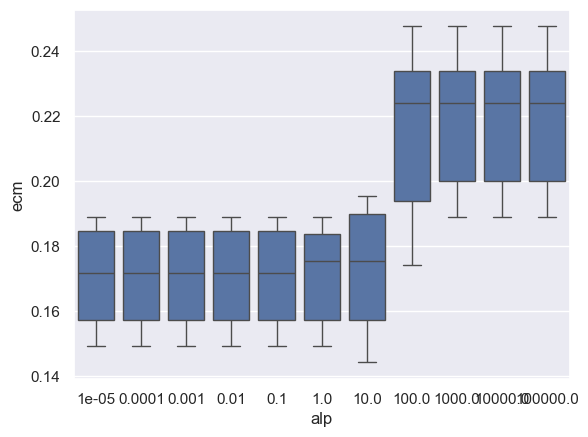

In [34]:
# Box plot para regularización LASSO

import seaborn as sns
sns.set()
ss = sns.boxplot(data=reg_lasso[1], x="alp", y="ecm")

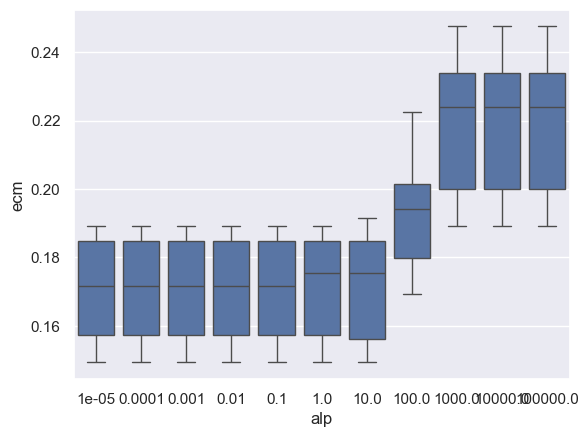

In [35]:
# Box plot para regularización Ridge

sns.set()
ss = sns.boxplot(data=reg_ridge[1], x="alp", y="ecm")

#### Ejercicio 6
En este caso, LASSO no elimina ningún coeficiente, aunque esto tiene sentido si pensamos que nos está eligiendo el menor valor posible de λ, 0.00001. Esto significaría que el parámetro C, la inversa de λ, es un valor muy alto, lo que implica una regularización más suave. Los coeficientes, como se muestra en el código de la celda inferior, tienen valores distintos a cero incluso bajo esta especificación, correspondiéndose estos con las variables que identificamos a priori en el inciso 1 de la parte I como relevantes para explicar la pobreza.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
lasso_best = Lasso(alpha=0.00001)
lasso_best.fit(x_train, y_train)
print(list(zip(lasso_best.coef_, x)))

[(0.0, 'const'), (-0.05394385257850865, 'IV1'), (0.15461410757256425, 'IV3'), (-0.07505821918863613, 'IV6'), (0.021681746339960773, 'IV7'), (0.05963836862855348, 'IV8'), (0.0508373383858604, 'IV9'), (0.03690356112162968, 'IV12_1'), (-0.01264402268369631, 'IV12_3'), (-0.006732030828532756, 'II7'), (0.00629937213568719, 'II8'), (-0.012672488242073895, 'V1'), (0.05425501781541823, 'V2'), (-0.4435891596907347, 'V5'), (-0.366866356258272, 'CH09'), (0.004641213749666287, 'CH10'), (-0.017693646018028957, 'CH11'), (-0.043073526866675274, 'CH12'), (-0.0026175555013566152, 'CH06')]


#### Ejercicio 7 

Acá va alguna descripción de porque elegimos el método.

In [ ]:
modelos = ["Logit"]
parametros = {"k_range": range(3,5), "penalty": ["l1", "l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} # l1enalty de Lasso, la l2 es Ridge. 

lasso_7 = evalua_multiples_metodos(modelos,x,y,parametros)

lasso_7[0]

#Chequear que sea efectivamente Logit

#### Ejercicio 8

#### Ejercicio 9 

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

lda_final = LinearDiscriminantAnalysis(n_components=1)
lda_final_fit = lda_final.fit(x_train, y_train)

y_pred = lda_final_fit.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

count = np.count_nonzero(y_pred == 1)

print("En base al modelo",lda_final,", la cantidad predicha de hogares pobres para la submuestra es de", count, "personas.")

proporcion = np.count_nonzero(y_pred == 1)/(len(y_pred))
proporcion = proporcion*100
print("La proporción de hogares pobres en la submuestra es del %.2f" % proporcion,"%.")

En base al modelo LinearDiscriminantAnalysis(n_components=1) , la cantidad predicha de hogares pobres para la submuestra es de 43 personas.
La proporción de hogares pobres en la submuestra es del 13.35 %.
